In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [3]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [4]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [5]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [6]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [7]:
class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCDuelingQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_value = nn.Linear(hidden_dims[-1], 1)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)      
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        v = self.output_value(x)
        a = self.output_layer(x)
        q = v.expand_as(a) + (a - a.mean(1, keepdim=True).expand_as(a))
        return q
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [8]:
class ReplayBuffer():

    def __init__(self, max_samples=100000, batch_size=32):
        self.memory = deque(maxlen=max_samples)
        self.batch_size = batch_size

    def store(self, sample):
        self.memory.append(sample)

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        idxs = np.random.choice(len(self.memory), batch_size)
        samples = np.array([self.memory[idx] for idx in idxs])
        batches = [np.vstack(batch_type) for batch_type in samples.T]
        return batches
    
    def is_prioritized(self):
        return False

    def __len__(self):
        return len(self.memory)

In [9]:
class PrioritizedReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=32, rank_based=False, 
                 alpha=0.7, beta0=0.5, beta_rate=0.999965, epsilon=0.001):
        self.memory = np.empty(shape=(max_samples, 3), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.index_index = 0
        self.td_error_index = 1
        self.sample_index = 2
        self.rank_based = rank_based # if not rank_based, then proportional
        self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
        self.beta = beta0 # bias correction 0 is no correction 1 is full correction
        self.beta0 = beta0 # beta0 is just beta's initial value
        self.beta_rate = beta_rate
        self.epsilon = epsilon

    def update(self, idxs, td_errors):
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)

    def store(self, sample):
        self.memory[self.n_entries, self.index_index] = self.n_entries
        priority = self.memory[:self.n_entries, self.td_error_index].max() if self.n_entries > 0 else 1.0
        self.memory[self.n_entries, self.td_error_index] = priority
        self.memory[self.n_entries, self.sample_index] = np.array(sample)
        self.n_entries += 1

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        entries = self.memory[:self.n_entries]

        if self.rank_based:
            entries = entries[entries[:, self.td_error_index].argsort()[::-1]]
            priorities = 1/(np.arange(self.n_entries) + 1)
        else: # proportional
            entries = entries[entries[:, self.td_error_index].argsort()[::-1]]
            priorities = entries[:, self.td_error_index] + self.epsilon

        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

        weights = (1.0/self.n_entries * 1.0/probs)**self.beta
        normalized_weights = weights/weights.max()

        idxs = np.random.choice(self.n_entries, batch_size, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        samples[:, self.td_error_index] = normalized_weights[idxs]
        
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(samples[:, self.index_index])
        weights_stack = np.vstack(samples[:, self.td_error_index])
        return idxs_stack, weights_stack, samples_stacks

    def is_prioritized(self):
        return True

    def __len__(self):
        return self.n_entries

In [10]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        model.eval()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy()
            return np.argmax(q_values)

In [11]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()

        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [12]:
class EGreedyDecayStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=1e-5, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        self.epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                           self.min_epsilon)
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [13]:
class StaircaseStrategy():
    def __init__(self, staircase):
        self.t = 0
        self.index = 0
        self.epsilon = list(staircase.keys())[self.index]
        self.staircase = staircase
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        if list(self.staircase.values())[self.index] and self.t > list(self.staircase.values())[self.index]:
            self.index += 1
            self.epsilon = list(staircase.keys())[self.index]
            self.t = 0

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [14]:
class SoftMaxStrategy():
    def __init__(self, init_temp=1.0, min_temp=0.5, exploration_ratio=0.9, max_steps=10000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            a = q_values - q_values.mean()
            probs = np.exp(a/temp) / np.sum(np.exp(a/temp))
            if sum(np.isnan(probs)):
                isnan = np.isnan(probs)
                probs[isnan] = 1.0/sum(isnan)
            
            assert np.isclose(probs.sum(), 1.0)
            action = np.random.choice(np.arange(len(q_values)), size=1, p=probs)[0]    
            self.exploratory_action_taken = action != np.argmax(q_values)
            return action

In [15]:
class DQNAgent():
    def __init__(self, buffer, model, optimizer, strategy, 
                 update_target_every_timesteps, train_every_timesteps, 
                 double_learning_enabled, soft_update_enabled,
                 tau, max_gradient, n_warmup_batch, 
                 print_every_episodes=25, save_every_episodes=500,
                 experiment_name='default', random_seed=12345):

        self.buffer = buffer()
        self.model_fn = model
        self.optimizer_fn = optimizer
        self.strategy = strategy()
        self.update_target_every_timesteps = update_target_every_timesteps
        self.train_every_timesteps = train_every_timesteps
        self.double_learning_enabled = double_learning_enabled
        self.soft_update_enabled = soft_update_enabled
        self.tau = tau
        self.max_gradient = max_gradient
        self.n_warmup_batch = n_warmup_batch
        self.print_every_episodes = print_every_episodes
        self.save_every_episodes = save_every_episodes
        self.experiment_name = experiment_name
        self.random_seed = random_seed

    def optimize_model(self, experiences):
        self.model.train()

        if self.buffer.is_prioritized():
            idxs, weights, (states, actions, rewards, next_states, is_terminals) = experiences
        else:
            states, actions, rewards, next_states, is_terminals = experiences
            weights, idxs = np.ones_like(rewards), None
        weights = torch.from_numpy(weights).float()
        batch_size = len(is_terminals)
        
        if self.double_learning_enabled:
            argmax_a_q_sp = self.model(next_states).detach().max(1)[1]
        else:
            argmax_a_q_sp = self.target(next_states).detach().max(1)[1]

        q_sp = self.target(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_s = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.model(states).gather(1, actions)

        td_errors = q_sa - target_q_s
        loss = (weights * td_errors).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-self.max_gradient, 
                                   self.max_gradient)
        self.optimizer.step()

        if self.buffer.is_prioritized():
            priorities = np.abs(td_errors.cpu().detach().numpy())
            self.buffer.update(idxs, priorities)
        
        
    def interaction_step(self, env, state):
        action = self.strategy.select_action(self.model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        experience = (state, action, reward, new_state, float(is_terminal))
        self.buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        print('Starting experiment:\n{}\n'.format('\n'.join(wrap(self.experiment_name.replace('_', ', '), 100))))
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        
        self.model = self.model_fn(nS, nA)
        self.model.eval()
        self.target = self.model_fn(nS, nA)
        self.target.eval()
        self.optimizer = self.optimizer_fn(self.model)
        
        for episode in range(1, max_episodes + 1):

            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for timestep in count(start=1):

                state, is_terminal = self.interaction_step(env, state)
                
                if len(self.buffer) > self.buffer.batch_size * self.n_warmup_batch:
                    
                    experiences = self.buffer.sample()
                    if self.buffer.is_prioritized():
                        idxs, weights, samples = experiences
                        experiences = self.model.load_experiences(samples)
                        experiences = (idxs, weights) + (experiences,)
                    else:
                        experiences = self.model.load_experiences(experiences)
                        
                    if np.sum(self.episode_timestep) % self.train_every_timesteps == 0:
                        self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_timesteps == 0:
                    if self.soft_update_enabled:
                        for target, network in zip(self.target.parameters(), 
                                                   self.model.parameters()):
                            mixed_weights = (1.0 - self.tau) * target.data + self.tau * network.data
                            target.data.copy_(mixed_weights)
                    else:
                        self.target.load_state_dict(self.model.state_dict())

                if is_terminal:
                    break

            mean_reward = np.mean(self.episode_reward[-100:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:04}, step {:06}, exploration rat {:.2f}, buff size {:06}, '
                debug_message += 'last ep rew {:03}, last 100 ep mean rew {:.2f}'
                debug_message = debug_message.format(
                    episode, self.episode_timestep[-1], episode_exploration_ratio, 
                    len(self.buffer), int(self.episode_reward[-1]), mean_reward)
                print(debug_message)

            if episode % self.save_every_episodes == 0 or mean_reward >= max_mean_reward:
                directory_name =  os.path.join('checkpoints', experiment_name.replace('_', '/'))
                filename = '{}_{}_{}.ckp'.format(episode, timestep, mean_reward)
                file_path =  os.path.join(directory_name, filename)
                if not os.path.exists(directory_name):
                    os.makedirs(directory_name)
                torch.save(self.model.state_dict(), file_path)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        print()
        return self.episode_reward

    
    def evaluate(self, env, strategy, episodes=10, render=True):
        rewards = []
        for episode in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in count(start=1):
                if render: env.render()
                action = strategy.select_action(self.model, state)
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        env.close()
        return rewards

In [16]:
env_name = 'CartPole-v0'
buffers = {
    'uniform': lambda: ReplayBuffer(
        max_samples=100000, batch_size=32),
    'prioritized': lambda: PrioritizedReplayBuffer(
        max_samples=100000, batch_size=32, rank_based=True, 
        alpha=0.7, beta0=0.5, beta_rate=0.999965, epsilon=0.001)
}

models = {
    'vanilla': lambda nS, nA: FCQ(
        nS, nA, hidden_dims=(64,64)),
    'dueling' : lambda nS, nA: FCDuelingQ(
        nS, nA, hidden_dims=(64,64)),
}

optimizers = {
    'adam': lambda net: optim.Adam(
        net.parameters(), lr=0.0005), 
    'rmsprop': lambda net: optim.RMSprop(
        net.parameters(), lr=0.0005)
}

strategies = {
    'egreedylinear': lambda: EGreedyLinearStrategy(
        init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1),
    'egreedyexponential': lambda: EGreedyLinearStrategy(
        init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1),
    'staircase': lambda: StaircaseStrategy(
        staircase={1.0:500, 0.25:1000, 0.5:1000, 0.25:5000, 0.1:None}),
    'softmax': lambda: SoftMaxStrategy(
        init_temp=1.0, min_temp=0.01, exploration_ratio=0.9, max_steps=10000)
}

update_target_every_timestepss = [5, 10, 20, 100]
train_every_timestepss = [2, 4, 8]
enable_double_learning = [True, False]
enable_soft_updates = [True]
taus = [0.01, 0.05, 0.10, 1.0]
max_gradients = [1, 2, 4, 8]
n_warmup_batches = [5, 10, 50]
random_seeds = [12, 34, 56, 78, 90]
gamma, max_episodes, max_mean_reward = 1.0, 1000, 200
print_every_episodes, save_every_episodes = 100, 500

training_results, evaluation_results = [], []
BestEnv = namedtuple('best_env', ['experiment_name', 'env', 'mean_reward', 'num_episodes'])
best_training_env = BestEnv(experiment_name='', env=None, mean_reward=float('-inf'), num_episodes=float('inf'))
best_evaluation_env = BestEnv(experiment_name='', env=None, mean_reward=float('-inf'), num_episodes=float('inf'))

for buffer in buffers:
    for model in models:
        for optimizer in optimizers:    
            for strategy in strategies:
                for update_target_every_timesteps in update_target_every_timestepss:
                    for train_every_timesteps in train_every_timestepss:
                        for double_learning_enabled in enable_double_learning:
                            for soft_update_enabled in enable_soft_updates:
                                for tau in taus:
                                    for max_gradient in max_gradients:
                                        for n_warmup_batch in n_warmup_batches:
                                            experiment_name = ''
                                            experiment_name += '{}_{}_{}_{}'
                                            experiment_name += '_update-target-every-timesteps-{}'
                                            experiment_name += '_train-every-timesteps-{}'
                                            experiment_name += '_double-learning-enabled-{}'
                                            experiment_name += '_soft-update-enabled-{}'
                                            experiment_name += '_tau-{}'
                                            experiment_name += '_max-gradient-{}'
                                            experiment_name += '_n-warmup-batch-{}'

                                            experiment_name = experiment_name.format(
                                                buffer, model, optimizer,  strategy, 
                                                update_target_every_timesteps, train_every_timesteps,
                                                double_learning_enabled, soft_update_enabled, tau,
                                                max_gradient, n_warmup_batch
                                            )
                                            
                                            training_rewards, evaluation_rewards = [], []
                                            for seed in random_seeds:
                                                print('Using seed {}'.format(seed))
                                                torch.manual_seed(seed)
                                                np.random.seed(seed)

                                                agent = DQNAgent(
                                                    buffers[buffer], models[model], optimizers[optimizer], 
                                                    strategies[strategy], 
                                                    update_target_every_timesteps, train_every_timesteps,
                                                    double_learning_enabled, soft_update_enabled, tau,
                                                    max_gradient, n_warmup_batch, 
                                                    print_every_episodes=print_every_episodes,
                                                    save_every_episodes=save_every_episodes, 
                                                    experiment_name=experiment_name)

                                                training_env = make_monitored_env(env_name, 'training', seed)
                                                rewards = agent.train(
                                                    training_env, gamma=gamma, 
                                                    max_episodes=max_episodes, max_mean_reward=max_mean_reward)
                                                training_rewards.append(rewards)
                                                # last 100 mean reward for training
                                                mean_reward = np.mean(rewards[-100:])
                                                num_episodes = len(rewards)
                                                if mean_reward > best_training_env.mean_reward or \
                                                   (mean_reward == best_training_env.mean_reward and \
                                                    num_episodes < best_training_env.num_episodes):
                                                    best_training_env = BestEnv(
                                                        experiment_name=experiment_name,
                                                        env=training_env, 
                                                        mean_reward=mean_reward, 
                                                        num_episodes=num_episodes)
                                                
                                                evaluation_env = make_monitored_env(env_name, 'evaluation', seed)
                                                rewards = agent.evaluate(
                                                    evaluation_env, GreedyStrategy(), episodes=10, render=False)
                                                evaluation_rewards.append(rewards)
                                                # for evaluation, just the mean reward of all runs
                                                mean_reward = np.mean(rewards)
                                                num_episodes = len(rewards)
                                                if mean_reward > best_evaluation_env.mean_reward or \
                                                   (mean_reward == best_evaluation_env.mean_reward and \
                                                    num_episodes < best_evaluation_env.num_episodes):
                                                    best_evaluation_env = BestEnv(
                                                        experiment_name=experiment_name,
                                                        env=evaluation_env, 
                                                        mean_reward=mean_reward, 
                                                        num_episodes=num_episodes)

                                            output = np.empty((len(training_rewards), max_episodes,))
                                            output[:] = float('-inf')
                                            for i, training_reward in enumerate(training_rewards):
                                                output[i, :len(training_reward)] = training_reward
                                            output = np.mean(output, axis=0)
                                            output = output[output>=0]
                                            training_results.append((output, experiment_name))
                                            
                                            output = np.empty((len(evaluation_rewards), max_episodes,))
                                            output[:] = float('-inf')
                                            for i, evaluation_reward in enumerate(evaluation_rewards):
                                                output[i, :len(evaluation_reward)] = evaluation_reward
                                            output = np.mean(output, axis=0)
                                            output = output[output>=0]
                                            evaluation_results.append((output, experiment_name))


Using seed 12
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-enabled-True, soft-update-enabled-True, tau-0.01, max-gradient-1, n-warmup-batch-5

ep 0100, step 0011.0, exploration rat 0.00, buff size 000960, last ep rew 011, last 100 ep mean rew 9.60
ep 0200, step 0010.0, exploration rat 0.00, buff size 001902, last ep rew 010, last 100 ep mean rew 9.42
ep 0300, step 0011.0, exploration rat 0.00, buff size 003170, last ep rew 011, last 100 ep mean rew 12.68
ep 0400, step 0143.0, exploration rat 0.02, buff size 009302, last ep rew 143, last 100 ep mean rew 61.32
ep 0500, step 0147.0, exploration rat 0.04, buff size 022823, last ep rew 147, last 100 ep mean rew 135.21
ep 0600, step 0186.0, exploration rat 0.07, buff size 039339, last ep rew 186, last 100 ep mean rew 165.16
ep 0700, step 0051.0, exploration rat 0.14, buff size 057523, last ep rew 051, last 100 ep mean rew 181.84
ep 0800, step 0147.0, exp

ep 0400, step 0021.0, exploration rat 0.05, buff size 003785, last ep rew 021, last 100 ep mean rew 9.79
ep 0500, step 0011.0, exploration rat 0.00, buff size 005258, last ep rew 011, last 100 ep mean rew 14.73
ep 0600, step 0051.0, exploration rat 0.06, buff size 008081, last ep rew 051, last 100 ep mean rew 28.23
ep 0700, step 0190.0, exploration rat 0.04, buff size 021104, last ep rew 190, last 100 ep mean rew 130.23
ep 0800, step 0159.0, exploration rat 0.04, buff size 038529, last ep rew 159, last 100 ep mean rew 174.25
ep 0900, step 0186.0, exploration rat 0.05, buff size 053996, last ep rew 186, last 100 ep mean rew 154.67
ep 1000, step 0200.0, exploration rat 0.06, buff size 073886, last ep rew 200, last 100 ep mean rew 198.90

Using seed 56
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-enabled-True, soft-update-enabled-True, tau-0.01, max-gradient-1, n-warmup-batch-10

ep 0100, step 0010.0,

ep 0600, step 0009.0, exploration rat 0.00, buff size 005625, last ep rew 009, last 100 ep mean rew 9.28
ep 0700, step 0010.0, exploration rat 0.00, buff size 006565, last ep rew 010, last 100 ep mean rew 9.40
ep 0800, step 0009.0, exploration rat 0.00, buff size 007509, last ep rew 009, last 100 ep mean rew 9.44
ep 0900, step 0008.0, exploration rat 0.00, buff size 008442, last ep rew 008, last 100 ep mean rew 9.33
ep 1000, step 0009.0, exploration rat 0.00, buff size 009380, last ep rew 009, last 100 ep mean rew 9.38

Using seed 90
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-enabled-True, soft-update-enabled-True, tau-0.01, max-gradient-1, n-warmup-batch-50

ep 0100, step 0009.0, exploration rat 0.11, buff size 001090, last ep rew 009, last 100 ep mean rew 10.90
ep 0200, step 0011.0, exploration rat 0.00, buff size 002084, last ep rew 011, last 100 ep mean rew 9.94
ep 0300, step 0009.0, explorat

ep 0100, step 0011.0, exploration rat 0.09, buff size 001031, last ep rew 011, last 100 ep mean rew 10.31
ep 0200, step 0010.0, exploration rat 0.00, buff size 002212, last ep rew 010, last 100 ep mean rew 11.81
ep 0300, step 0143.0, exploration rat 0.05, buff size 008973, last ep rew 143, last 100 ep mean rew 67.61
ep 0400, step 0200.0, exploration rat 0.03, buff size 028518, last ep rew 200, last 100 ep mean rew 195.45
ep 0500, step 0200.0, exploration rat 0.04, buff size 048098, last ep rew 200, last 100 ep mean rew 195.80
ep 0600, step 0200.0, exploration rat 0.07, buff size 067965, last ep rew 200, last 100 ep mean rew 198.67
ep 0700, step 0200.0, exploration rat 0.09, buff size 087677, last ep rew 200, last 100 ep mean rew 197.12
ep 0800, step 0200.0, exploration rat 0.06, buff size 100000, last ep rew 200, last 100 ep mean rew 198.41
ep 0900, step 0200.0, exploration rat 0.06, buff size 100000, last ep rew 200, last 100 ep mean rew 199.83
ep 0910, step 0200.0, exploration rat 0.

ep 0800, step 0200.0, exploration rat 0.06, buff size 041904, last ep rew 200, last 100 ep mean rew 188.85
ep 0900, step 0161.0, exploration rat 0.04, buff size 059148, last ep rew 161, last 100 ep mean rew 172.44
ep 1000, step 0200.0, exploration rat 0.06, buff size 077678, last ep rew 200, last 100 ep mean rew 185.30

Using seed 56
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-enabled-True, soft-update-enabled-True, tau-0.01, max-gradient-2, n-warmup-batch-50

ep 0100, step 0011.0, exploration rat 0.18, buff size 002448, last ep rew 011, last 100 ep mean rew 24.48
ep 0200, step 0011.0, exploration rat 0.00, buff size 003698, last ep rew 011, last 100 ep mean rew 12.50
ep 0300, step 0200.0, exploration rat 0.04, buff size 012515, last ep rew 200, last 100 ep mean rew 88.17
ep 0400, step 0200.0, exploration rat 0.07, buff size 031785, last ep rew 200, last 100 ep mean rew 192.70
ep 0500, step 0200.0

ep 0100, step 0010.0, exploration rat 0.00, buff size 000945, last ep rew 010, last 100 ep mean rew 9.45
ep 0200, step 0010.0, exploration rat 0.00, buff size 001892, last ep rew 010, last 100 ep mean rew 9.47
ep 0300, step 0010.0, exploration rat 0.00, buff size 002825, last ep rew 010, last 100 ep mean rew 9.33
ep 0400, step 0010.0, exploration rat 0.00, buff size 003765, last ep rew 010, last 100 ep mean rew 9.40
ep 0500, step 0009.0, exploration rat 0.00, buff size 004697, last ep rew 009, last 100 ep mean rew 9.32
ep 0600, step 0009.0, exploration rat 0.00, buff size 005625, last ep rew 009, last 100 ep mean rew 9.28
ep 0700, step 0010.0, exploration rat 0.00, buff size 006565, last ep rew 010, last 100 ep mean rew 9.40
ep 0800, step 0009.0, exploration rat 0.00, buff size 007509, last ep rew 009, last 100 ep mean rew 9.44
ep 0900, step 0008.0, exploration rat 0.00, buff size 008442, last ep rew 008, last 100 ep mean rew 9.33
ep 1000, step 0009.0, exploration rat 0.00, buff size 0

ep 0900, step 0200.0, exploration rat 0.05, buff size 093455, last ep rew 200, last 100 ep mean rew 198.86
ep 1000, step 0200.0, exploration rat 0.09, buff size 100000, last ep rew 200, last 100 ep mean rew 196.56

Using seed 12
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-enabled-True, soft-update-enabled-True, tau-0.01, max-gradient-4, n-warmup-batch-50

ep 0100, step 0023.0, exploration rat 0.00, buff size 001832, last ep rew 023, last 100 ep mean rew 18.32
ep 0200, step 0010.0, exploration rat 0.00, buff size 003108, last ep rew 010, last 100 ep mean rew 12.76
ep 0300, step 0103.0, exploration rat 0.07, buff size 008101, last ep rew 103, last 100 ep mean rew 49.93
ep 0400, step 0200.0, exploration rat 0.09, buff size 025440, last ep rew 200, last 100 ep mean rew 173.39
ep 0500, step 0200.0, exploration rat 0.06, buff size 042663, last ep rew 200, last 100 ep mean rew 172.23
ep 0600, step 0200.0

ep 0100, step 0010.0, exploration rat 0.00, buff size 000940, last ep rew 010, last 100 ep mean rew 9.40
ep 0200, step 0010.0, exploration rat 0.00, buff size 001865, last ep rew 010, last 100 ep mean rew 9.25
ep 0300, step 0009.0, exploration rat 0.00, buff size 002801, last ep rew 009, last 100 ep mean rew 9.36
ep 0400, step 0009.0, exploration rat 0.11, buff size 003724, last ep rew 009, last 100 ep mean rew 9.23
ep 0500, step 0010.0, exploration rat 0.00, buff size 004666, last ep rew 010, last 100 ep mean rew 9.42
ep 0600, step 0010.0, exploration rat 0.00, buff size 005601, last ep rew 010, last 100 ep mean rew 9.35
ep 0700, step 0008.0, exploration rat 0.00, buff size 006540, last ep rew 008, last 100 ep mean rew 9.39
ep 0800, step 0011.0, exploration rat 0.09, buff size 007552, last ep rew 011, last 100 ep mean rew 10.12
ep 0900, step 0010.0, exploration rat 0.00, buff size 008607, last ep rew 010, last 100 ep mean rew 10.55
ep 1000, step 0013.0, exploration rat 0.15, buff size

ep 0500, step 0200.0, exploration rat 0.03, buff size 044889, last ep rew 200, last 100 ep mean rew 185.02
ep 0600, step 0190.0, exploration rat 0.05, buff size 064557, last ep rew 190, last 100 ep mean rew 196.68
ep 0700, step 0200.0, exploration rat 0.05, buff size 083894, last ep rew 200, last 100 ep mean rew 193.37
ep 0800, step 0200.0, exploration rat 0.06, buff size 100000, last ep rew 200, last 100 ep mean rew 198.76
ep 0822, step 0200.0, exploration rat 0.10, buff size 100000, last ep rew 200, last 100 ep mean rew 200.00
Training complete

Using seed 78
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-enabled-True, soft-update-enabled-True, tau-0.01, max-gradient-8, n-warmup-batch-10

ep 0100, step 0010.0, exploration rat 0.00, buff size 000945, last ep rew 010, last 100 ep mean rew 9.45
ep 0200, step 0010.0, exploration rat 0.00, buff size 001892, last ep rew 010, last 100 ep mean rew 9.47
ep 

ep 0300, step 0009.0, exploration rat 0.00, buff size 003027, last ep rew 009, last 100 ep mean rew 9.43
ep 0400, step 0009.0, exploration rat 0.00, buff size 003953, last ep rew 009, last 100 ep mean rew 9.26
ep 0500, step 0019.0, exploration rat 0.00, buff size 005522, last ep rew 019, last 100 ep mean rew 15.69
ep 0600, step 0167.0, exploration rat 0.07, buff size 013881, last ep rew 167, last 100 ep mean rew 83.59
ep 0700, step 0198.0, exploration rat 0.06, buff size 032955, last ep rew 198, last 100 ep mean rew 190.74
ep 0800, step 0200.0, exploration rat 0.07, buff size 052572, last ep rew 200, last 100 ep mean rew 196.17
ep 0900, step 0200.0, exploration rat 0.04, buff size 072261, last ep rew 200, last 100 ep mean rew 196.89
ep 1000, step 0146.0, exploration rat 0.03, buff size 090738, last ep rew 146, last 100 ep mean rew 184.77

Using seed 12
Starting experiment:
uniform, vanilla, adam, egreedylinear, update-target-every-timesteps-5, train-every-timesteps-2,
double-learning-e

KeyboardInterrupt: 

In [21]:
print(best_training_env)

best_env(experiment_name='uniform_vanilla_adam_egreedylinear_update-target-every-timesteps-5_train-every-timesteps-2_double-learning-enabled-True_soft-update-enabled-True_tau-0.01_max-gradient-4_n-warmup-batch-50', env=<Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>, mean_reward=147.0308510638298, num_episodes=940)


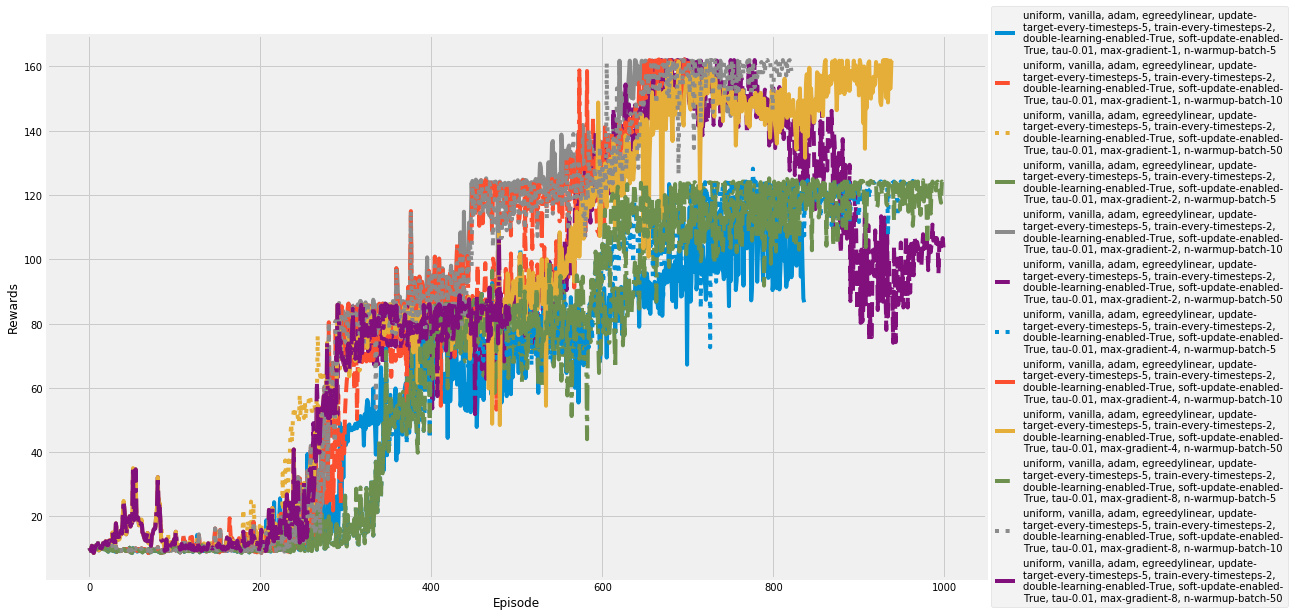

In [17]:
plot_results(training_results, log_scale=False)

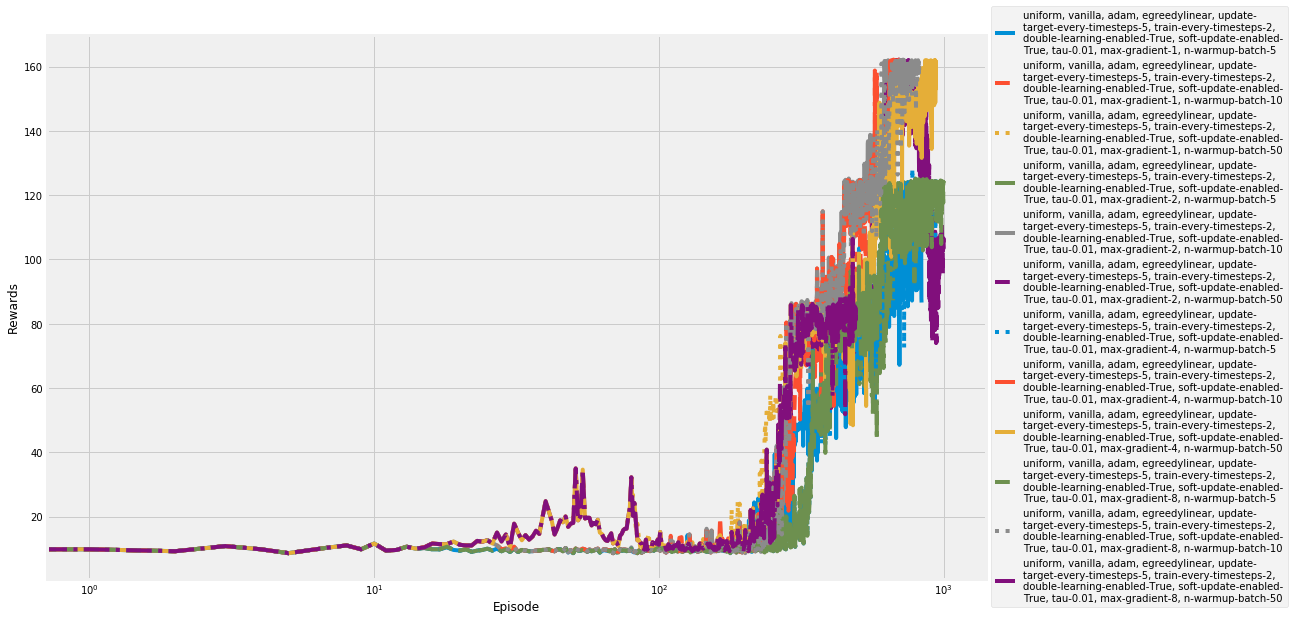

In [18]:
plot_results(training_results, log_scale=True)


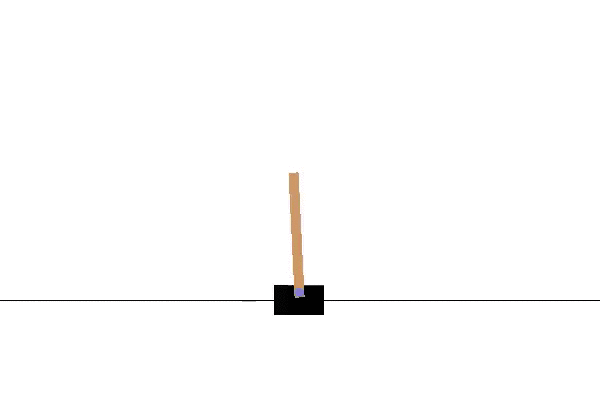
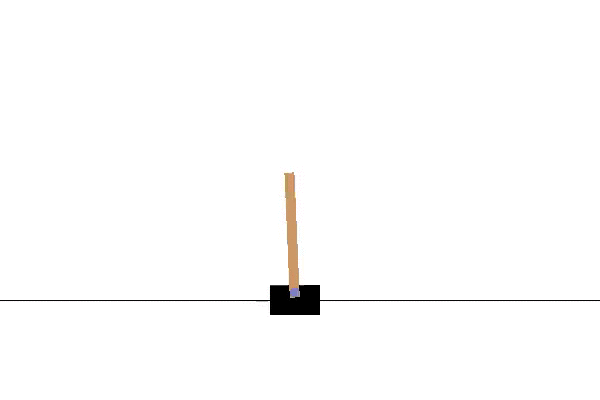
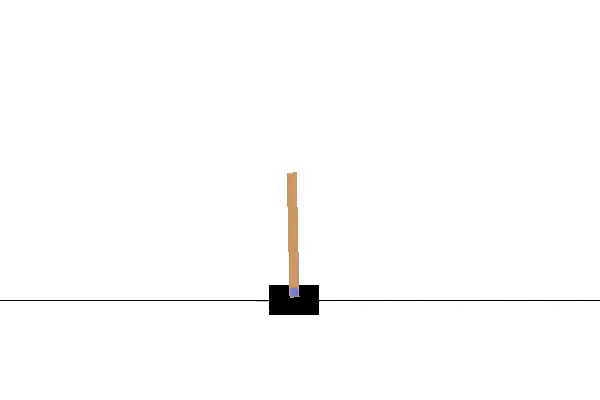
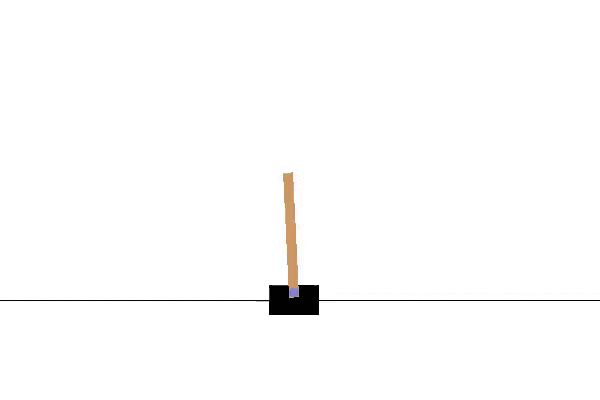
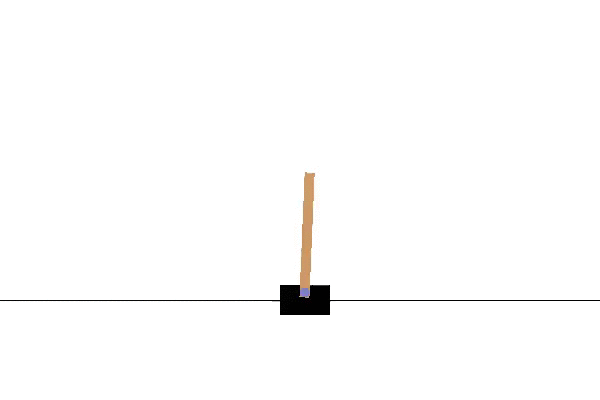

In [25]:
HTML(data=get_gif_html(env_videos=best_training_env.env.videos, title='Training evolution', max_n_videos=5))

In [22]:
print(best_evaluation_env)

best_env(experiment_name='uniform_vanilla_adam_egreedylinear_update-target-every-timesteps-5_train-every-timesteps-2_double-learning-enabled-True_soft-update-enabled-True_tau-0.01_max-gradient-1_n-warmup-batch-5', env=<Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>, mean_reward=200.0, num_episodes=10)


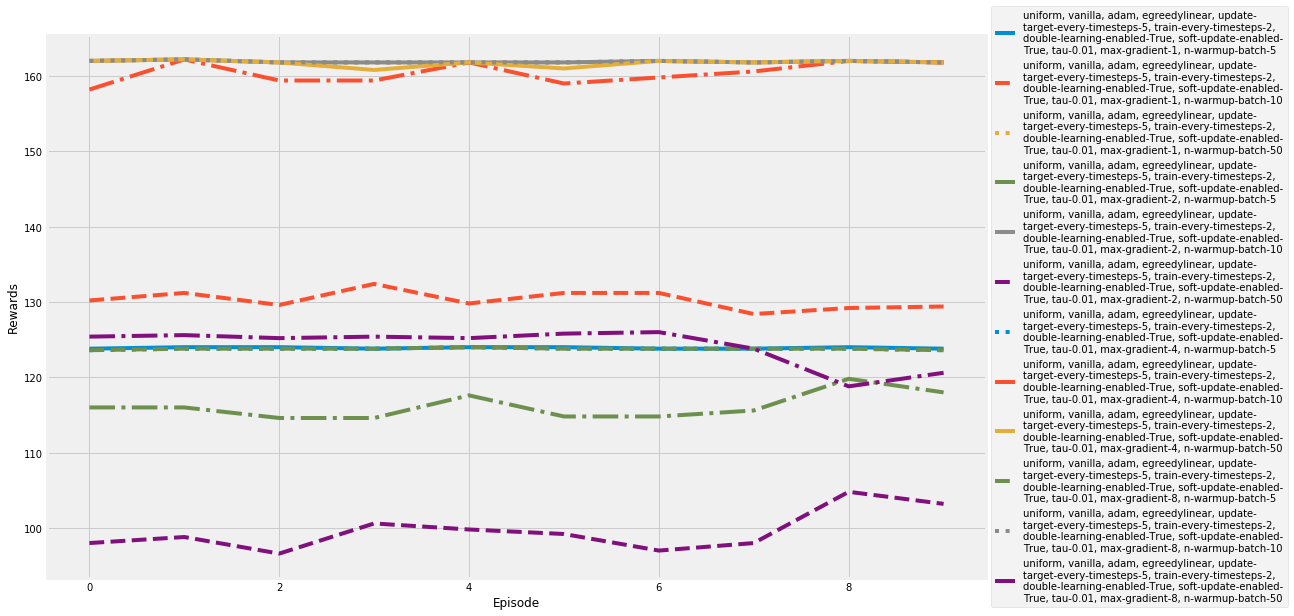

In [23]:
plot_results(evaluation_results, log_scale=False)

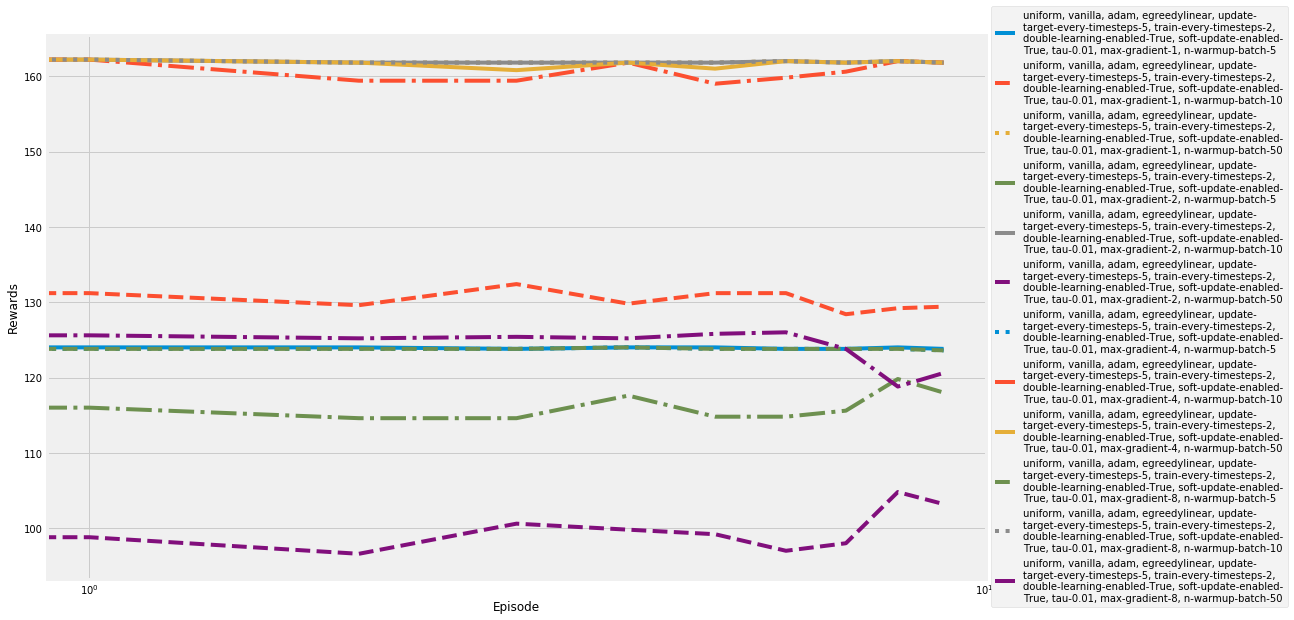

In [24]:
plot_results(evaluation_results, log_scale=True)


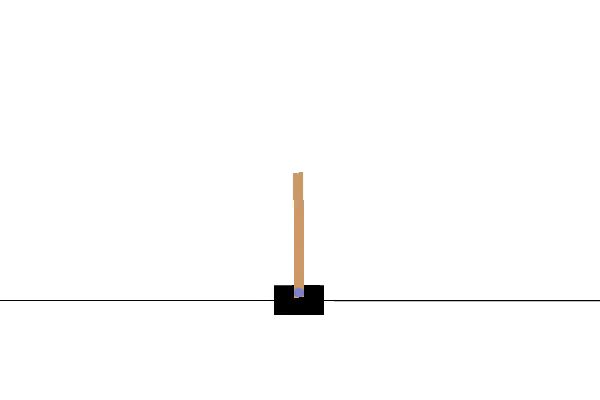
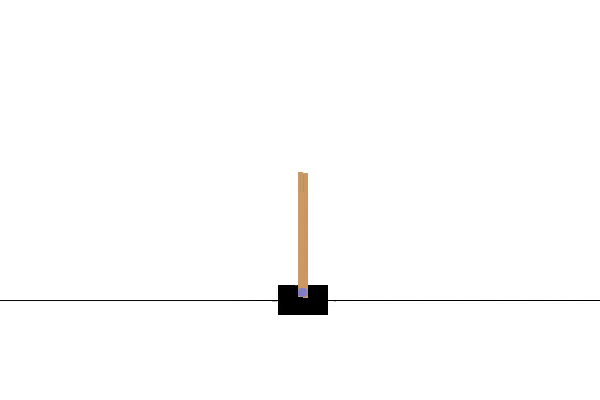
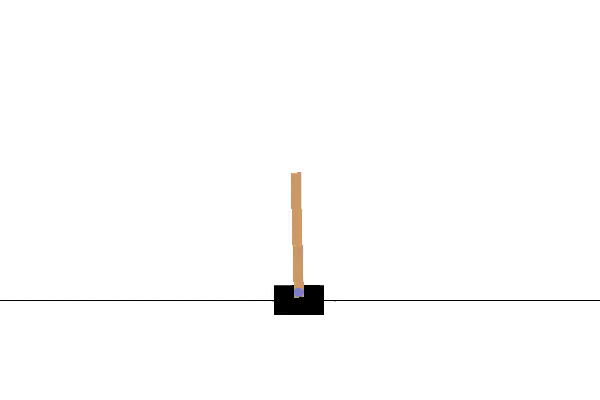

In [26]:
HTML(data=get_gif_html(env_videos=best_evaluation_env.env.videos, title='Evaluation results', max_n_videos=3))